In [1]:
import pandas as pd
import numpy as np
import torch
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib
import shap
import matplotlib.pyplot as plt
import sys
import gc
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Add src to path
sys.path.append('../src')
from model import MultiTaskTabNet

# Visualization Settings
shap.initjs()
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12


In [2]:
# 1. Load All Models for the Ensemble
print("Loading Ensemble Components...")

# A. Load Meta-Learner (The Judge)
try:
    meta_model = joblib.load('../outputs/models/meta_learner_logistic.pkl')
    print(f"✅ Meta-Learner Loaded. Weights: {meta_model.coef_[0]}")
except FileNotFoundError:
    print("❌ Error: Meta-learner not found. Did you run Notebook 06?")

# B. Load LightGBM (The Tree)
lgbm_model = lgb.Booster(model_file='../outputs/models/lgbm_baseline.txt')

# C. Load Standard TabNet (The Neural Baseline)
tabnet_std = TabNetClassifier()
tabnet_std.load_model('../outputs/models/tabnet_credit_baseline.zip')

# D. Load Asymmetric MTL (Your Custom Arch)
# We need to infer dimensions to initialize the class
SHARED_DIM = 50
device = torch.device('cpu')

# Load a tiny sample just to get input dimensions
raw_sample = pd.read_parquet('../data/processed/train.parquet').iloc[:5]
X_sample_raw = raw_sample.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1).fillna(-999)
input_dim = SHARED_DIM
private_dim = X_sample_raw.shape[1] - SHARED_DIM

mtl_model = MultiTaskTabNet(input_dim=input_dim, private_dim=private_dim)
mtl_model.load_state_dict(torch.load('../outputs/models/unified_mtl_best.pth', map_location=device))
mtl_model.eval()

print("✅ All Base Models Loaded Successfully.")

Loading Ensemble Components...
✅ Meta-Learner Loaded. Weights: [ 1.67702063e+01 -3.23661310e-03 -5.64962268e-01]
✅ All Base Models Loaded Successfully.


In [3]:
# 2. Define the Ensemble Wrapper
# This function mimics your entire production pipeline
def ensemble_predict(X_numpy):
    """
    Takes raw feature rows -> Runs 3 Models -> Stacks Probabilities -> Returns Final Risk Score
    """
    # X_numpy is passed by SHAP as a numpy array
    
    # --- 1. LightGBM Prediction ---
    pred_lgbm = lgbm_model.predict(X_numpy)
    
    # --- 2. TabNet Prediction ---
    # TabNet expects numpy, outputs [Prob_0, Prob_1]
    pred_tabnet = tabnet_std.predict_proba(X_numpy)[:, 1]
    
    # --- 3. MTL Prediction ---
    # MTL needs Torch Tensors and Split Inputs
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    x_shared = X_tensor[:, :SHARED_DIM]
    x_private = X_tensor[:, SHARED_DIM:]
    
    with torch.no_grad():
        _, pred_mtl = mtl_model(x_shared, x_private)
    pred_mtl = pred_mtl.numpy().flatten()
    
    # --- 4. Stacking ---
    # Stack them: [LGBM, TabNet, MTL]
    X_stack = np.column_stack((pred_lgbm, pred_tabnet, pred_mtl))
    
    # Final Probability from Meta-Learner
    final_prob = meta_model.predict_proba(X_stack)[:, 1]
    
    return final_prob

print("Ensemble Wrapper Defined.")

Ensemble Wrapper Defined.


In [4]:
# 3. Prepare Data for SHAP
# SHAP KernelExplainer is slow, so we use K-Means to summarize the background.
print("Preparing Data...")

# Load a sample of 200 rows
df = pd.read_parquet('../data/processed/train.parquet').sample(10000, random_state=42)
X_eval = df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1).fillna(-999)

# Summary Background: 
# Reduces 200 rows down to 10 weighted "centroid" rows. 
# This makes the explanation 20x faster while keeping accuracy high.
background_summary = shap.kmeans(X_eval, 10)

# Rows to Explain:
# We will explain the first 10 rows.
X_to_explain = X_eval.iloc[:1000]

print(f"Background summarized. Ready to explain {len(X_to_explain)} transactions.")

Preparing Data...
Background summarized. Ready to explain 1000 transactions.


In [5]:
# 4. Run SHAP (The Heavy Lifting)
print("Starting SHAP KernelExplainer...")

# Link the wrapper function and the background data
explainer = shap.KernelExplainer(ensemble_predict, background_summary)

# Calculate SHAP values
shap_values = explainer.shap_values(X_to_explain)

print("✅ SHAP Calculation Complete.")

Starting SHAP KernelExplainer...


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ SHAP Calculation Complete.


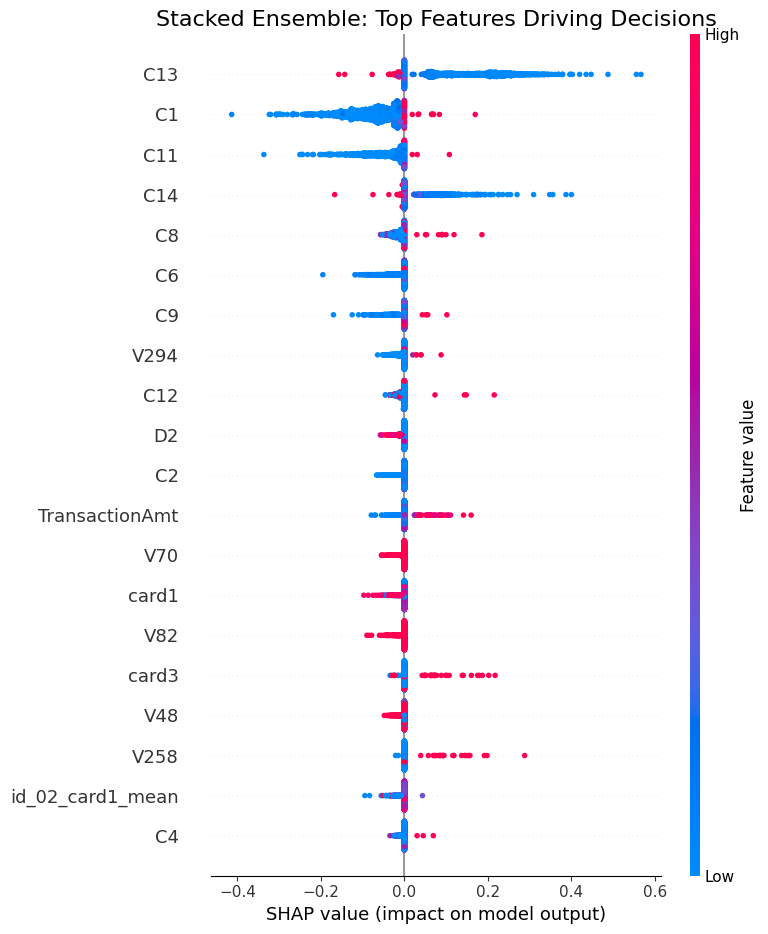

In [6]:
# 5. Global Feature Importance (Summary Plot)
# Shows the top features driving the ENSEMBLE'S decisions
plt.figure()
plt.title("Stacked Ensemble: Top Features Driving Decisions", fontsize=16)
shap.summary_plot(shap_values, X_to_explain, show=True)

Explaining Transaction #0
Final Ensemble Risk Score: 0.0058


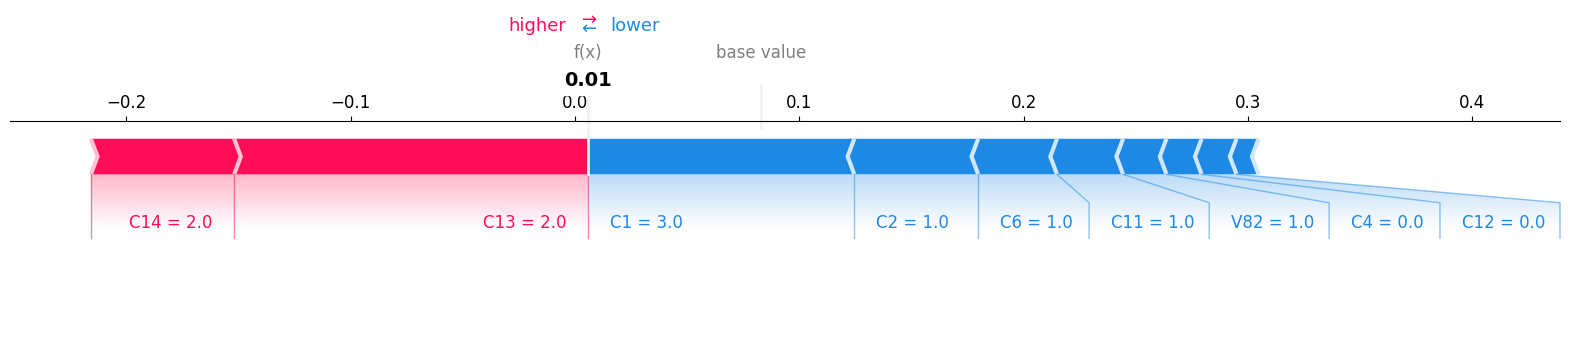

In [7]:
# 6. Local Explanation (Force Plot)
# Explain the first transaction in the batch
print(f"Explaining Transaction #0")
print(f"Final Ensemble Risk Score: {ensemble_predict(X_to_explain.values[0:1])[0]:.4f}")

shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_to_explain.iloc[0], 
    matplotlib=True
)

Plotting interaction for Ensemble's top feature: C13


<Figure size 1000x800 with 0 Axes>

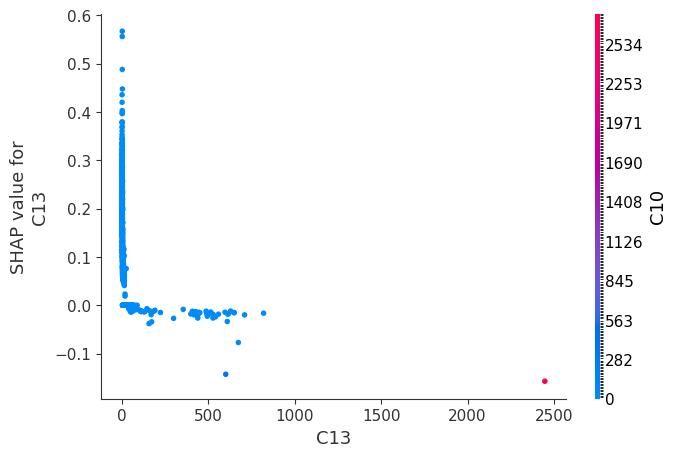

In [8]:
# Cell 8
# 7. Feature Interaction (Dependence Plot)
# Let's see how the #1 most important feature interacts with the rest of the Ensemble.

# Automatically find the most important feature index
top_feature_idx = np.argmax(np.abs(shap_values).mean(0))
top_feature_name = X_to_explain.columns[top_feature_idx]

print(f"Plotting interaction for Ensemble's top feature: {top_feature_name}")

plt.figure(figsize=(10, 8))
shap.dependence_plot(
    top_feature_name, 
    shap_values, 
    X_to_explain, 
    interaction_index='auto' # Let SHAP find the interesting interaction
)